In [1]:
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import dill as pickle
import scipy.stats as sps
from surmise.calibration import calibrator 
from surmise.emulation import emulator
import src.Smooth as Smooth
import src.Smooth as Smooth
import src.design_points as design_points   
import src.plots as plots
import pandas as pd
import corner
from matplotlib.lines import Line2D
import shutil
import subprocess
import bilby


os.environ['Smooth_PATH'] = '/Users/christalmartin/BAND_fellowship/BAND_example/bandframework/software/SmoothEmulator/'
smooth_path = os.environ['Smooth_PATH']

if not os.path.exists(smooth_path):
    print("SmoothEmulator not found. Installing...")
    Smooth.install_smooth_emulator(smooth_path)
else:
    print(f"SmoothEmulator already installed at {smooth_path}. Using it.")

os.environ['Work_PATH'] = os.getcwd()
work_path = os.environ['Work_PATH']

SmoothEmulator already installed at /Users/christalmartin/BAND_fellowship/BAND_example/bandframework/software/SmoothEmulator/. Using it.


## Parameters for Comparison Plots

In [2]:
seed = 0    #random seed for latin hypercube sampling
dmax = False #turn detmax on or off
train_size = 20
validation_size = 30

Samples = 100

clear = True #clear out the old files
skip_cell = False

## Model and Priors

Toy model:

$R_{AA}(p_T, s_{NN})_{A,B,C,D,E} = \frac{1}{2\pi} \left(A + B e^{-0.5(p_T - C)^2} + \ln\left( Dp_T + (\text{cent}*s_{NN})^E \right)\right)$ and  $\text{cent} = 0.05$ for central collisions 

In [3]:
#parameter space for theta = [A, B, C, ...]
priors = {
    'A': bilby.core.prior.Uniform(minimum=0.5, maximum=3.0), 
    'B': bilby.core.prior.Uniform(minimum=1.0, maximum=1.8), 
    'C': bilby.core.prior.Uniform(minimum=-1.6, maximum=0.0),
    'D': bilby.core.prior.Uniform(minimum=0.0, maximum=0.2),
    'E': bilby.core.prior.Uniform(minimum=-1.5, maximum=0.0)
}

#####################

#ToyModel for R_AA
def R_AA(pT, params, cent, sNN):
    A, B, C, D, E = params  
    X = D * pT + (cent * sNN)**E
    if np.all(X > 0):
            return 1 / (2 * np.pi) * (A + B * np.exp(-((pT - C) ** 2) / 2) + np.log(X))
    else:
        print('Warning: Negative R_AA value')
        return -np.inf

######################
pT = {}

pT['AuAu200'] = [9.75, 11.0, 13.0, 15.0, 17.0, 19.0]
pT['PbPb2760' ] = [10.8, 12.3, 14.1, 16.2, 18.6, 21.4, 24.4, 28.1, 33.9, 42.6, 53.6, 67.5, 85.]
pT['PbPb5020'] = [13.2, 16.8, 21.6, 26.4, 32., 38.4, 44.8, 54.4, 67.2, 80., 95.]

parameter_names = list(priors.keys())
dim = len(parameter_names) 
train_points, validation_points = design_points.load_data(train_size, validation_size, priors, seed, dmax)


In [4]:
if clear:
    directories = ['smooth_emulators', 'surmise']

    for directory in directories:
        if os.path.exists(directory):
            for filename in os.listdir(directory):
                file_path = os.path.join(directory, filename)
                if os.path.isdir(file_path):
                    shutil.rmtree(file_path)  # Remove the directory and its contents
                    print(f"Deleted directory: {file_path}")
        else:
            print(f"Directory {directory} does not exist.")

Deleted directory: smooth_emulators/PbPb5020
Deleted directory: smooth_emulators/PbPb2760
Deleted directory: smooth_emulators/AuAu200


## Toy Model Predictions

/var/folders/pc/3lmx_56x2pl6g3ngs7b_n4dw0000gn/T/ipykernel_77870/1036754275.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=30, loc='upper right', bbox_to_anchor=(1, 1))


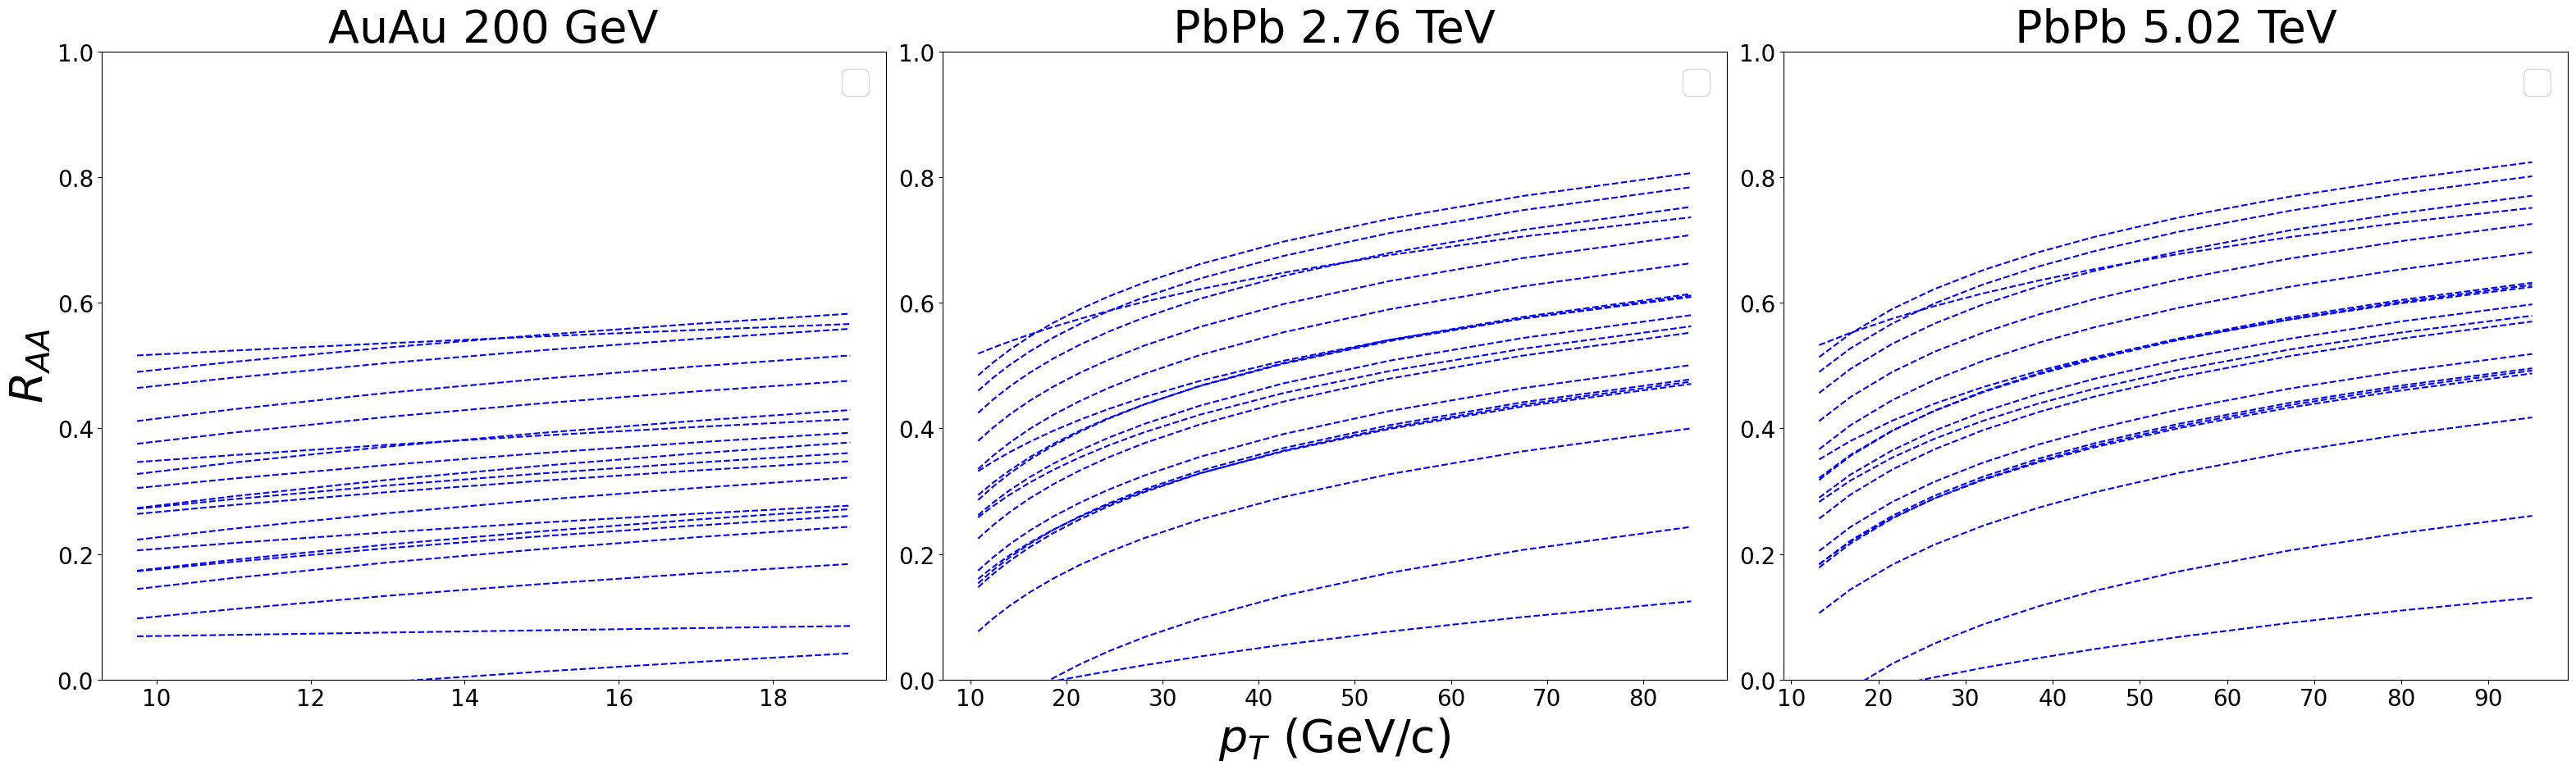

In [5]:
RAA = {}
y_train_results = {}
y_val_results = {}
total_low = {}
total_high = {}

fig, axes = plt.subplots(1, 3, figsize=(35, 10))

mean_ = 0.05 
std_dev_ = 0.01

param_ = {
    key: (prior.minimum + prior.maximum) / 2
    for key, prior in priors.items()
}
param0 = np.array(list(param_.values()))

for i, system in enumerate(['AuAu200', 'PbPb2760', 'PbPb5020']):
    ax = axes[i] 
    experiment = 'PHENIX' if system == 'AuAu200' else 'ATLAS' if system == 'PbPb2760' else 'CMS' 
    coll = 'AuAu' if system == 'AuAu200' else 'PbPb' if system == 'PbPb2760' else 'PbPb'
    energy = '200 GeV' if system == 'AuAu200' else '2.76 TeV' if system == 'PbPb2760' else '5.02 TeV'
    cent_val = 0.05
    sNN = 200 if 'AuAu' in system else 2760 if 'PbPb2760' in system else 5020
    pT[system] = np.array(pT[system])

    RAA[system] = np.array([R_AA(pT[system][i], param0, cent_val, sNN)
                                       for i in range(pT[system].shape[0])])

    total_low[system] = np.random.normal(loc=mean_, scale=std_dev_, size=pT[system].shape)
    total_high[system] = np.random.normal(loc=mean_, scale=std_dev_, size=pT[system].shape)
    sigma = total_high[system] 

    y_train = np.array([R_AA(pT[system], train_points.T[:, i], cent_val, sNN) for i in range(train_points.T.shape[1])])
    y_val = np.array([R_AA(pT[system], validation_points.T[:, i], cent_val, sNN) for i in range(validation_points.T.shape[1])])
    
    y_train_results[system] = y_train
    y_val_results[system] = y_val

    for j in range(y_train_results[system].shape[0]):  
            ax.plot(pT[system], y_train_results[system][j, :], 
            color='blue', linestyle='--')

    # Set labels and title
    ax.set_title(f'{coll} {energy}', fontsize=40)
    ax.set_ylim(0, 1)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.xaxis.set_tick_params(labelsize=20)
    
    if i == 0:  # Set ylabel only for the first subplot
        ax.set_ylabel('$R_{AA}$', fontsize=40)
        label = f'{experiment}: $0-10\\%$ Centrality'
    elif i == 1:
        ax.set_xlabel('$p_T$ (GeV/c)', fontsize=40)
        label = f'{experiment}: $0-5\\%$ Centrality'
    else:
        label = f'{experiment}: $0-10\\%$ Centrality'
        
    #ax.errorbar(pT[system], data_groups[sy + cent][0][1], yerr=[data_groups[sy + cent][0][2] + data_groups[sy + cent][0][4], data_groups[sy + cent][0][3] + data_groups[sy + cent][0][5]], 
                     #   color='black', fmt='o', markersize=8, capsize=8, label=label)
    
    ax.legend(fontsize=30, loc='upper right', bbox_to_anchor=(1, 1))

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()



## Train Smooth Emulator: https://github.com/bandframework/bandframework/blob/main/software/SmoothEmulator/doc/UserManual.pdf

In [6]:
Smooth_train_mean = {}
Smooth_train_errors = {}
Smooth_val_mean = {}
Smooth_val_errors = {}

Smooth_train_mean, Smooth_train_errors, Smooth_val_mean, Smooth_val_errors = [{} for _ in range(4)]

for system in ['AuAu200', 'PbPb2760', 'PbPb5020']:
    Smooth.fit(x=pT[system], theta=train_points, f=y_train_results[system], priors=priors, label=system, order=5, Lambda=0.8)
    Smooth_train_mean[system], Smooth_train_errors[system] = Smooth.predict(train_points, system)
    Smooth_val_mean[system], Smooth_val_errors[system] = Smooth.predict(validation_points, system)
    os.chdir(work_path)   
        

## Train Surmise Emulator : https://surmise.readthedocs.io/en/latest/

In [7]:
Emulators = {}
Surmise_val = {}
Surmise_train = {}
    
for system in ['AuAu200', 'PbPb2760', 'PbPb5020']:
    Emulators[system] = emulator(x=pT[system], theta=train_points, f=y_train_results[system].T, method='indGP')

    Surmise_val[system] = Emulators[system].predict(x=pT[system], theta=validation_points).mean().T
    Surmise_train[system] = Emulators[system].predict(x=pT[system], theta=train_points).mean().T    

## Likelihood with emulators for MCMC Calibration (using bilby: https://lscsoft.docs.ligo.org/bilby/samplers.html)

In [8]:
from bilby.core.prior import PriorDict, Uniform, Constraint

class GaussianLikelihood(bilby.Likelihood):
    def __init__(self, x, y, sigma, emulator, label, em_type):
        self.x = x
        self.y = y
        self.sigma = sigma
        self.N = len(x)
        self.emulator = emulator
        self.em_type = em_type
        self.label = label
        super().__init__(parameters=dict())

    def log_likelihood(self):
        # Extract parameters
        params = np.array([self.parameters[key] for key in ['A', 'B', 'C', 'D', 'E']])
        
        try:
            # Make predictions using the emulator
            if self.em_type == 'smooth':
                NObs = self.emulator.GetNObs() 
                X = params
                Y = np.zeros(NObs,dtype='float')
                SigmaY = np.zeros(NObs,dtype='float')
                theta = self.emulator.GetThetaFromX(X)
                self.emulator.TuneAllY()
                for iY in range(NObs):
                    Y[iY], SigmaY[iY] = self.emulator.GetYSigmaPython(iY, theta)
                model = np.array(Y)
                error = np.array(SigmaY)
                model = np.squeeze(model)
                error = np.squeeze(error)
                
            elif self.em_type == 'surmise':
                model = np.squeeze(self.emulator.predict(self.x, params).mean())
                var = np.squeeze(self.emulator.predict(self.x, params).var())
                error = np.sqrt(var)
                
            self.sigma = np.asarray(self.sigma)
            error = np.asarray(error)

            # Compute residuals
            res = self.y - model

            var_safe = self.sigma ** 2 + error ** 2  + 1e-10  # Add a small number to avoid zero values
            sigma_safe = np.sqrt(var_safe)  

            # Calculate log-likelihood
            log_l = -0.5 * np.sum((res / sigma_safe) ** 2 + np.log(2 * np.pi * sigma_safe ** 2))

            # Check for NaN or inf in log-likelihood
            if np.isnan(log_l) or np.isinf(log_l):
                return -np.inf  # Return a very low likelihood if invalid values are encountered
            return log_l

        except Exception as e:
            return -np.inf  # Return a very low likelihood if there's an exception

## Checks if MCMC has already been ran and will start random walkers where they stopped

In [9]:
sur_pos = {}
smooth_pos = {}
pos = False

if os.path.exists('pos0.txt'):
    pos = True

    with open('pos0.txt', 'r') as f:
        lines = f.readlines()

    current_system = None

    i = 0
    while i < len(lines):
        if lines[i].startswith("sur_pos_"):
            header = lines[i].strip().split("_")
            current_system = header[2]  # e.g., 'AuAu200'
            i += 1
            sur_pos_data = []

            # Collect sur_pos data until a new header or smooth_pos is found
            while i < len(lines) and not lines[i].startswith(f"smooth_pos") and not lines[i].startswith(f"sur_pos_"):
                sur_pos_data.append([float(x) for x in lines[i].strip().split(',')])
                i += 1
            sur_pos[f"{current_system}"] = np.array(sur_pos_data)
            print(f"sur_pos processed for {current_system}")

        elif lines[i].startswith(f"smooth_pos_{current_system}"):
            i += 1
            smooth_pos_data = []

            # Collect smooth_pos data until a new header or sur_pos is found
            while i < len(lines) and not lines[i].startswith(f"sur_pos_") and not lines[i].startswith(f"smooth_pos_"):
                smooth_pos_data.append([float(x) for x in lines[i].strip().split(',')])
                i += 1
            smooth_pos[f"{current_system}"] = np.array(smooth_pos_data)
            print(f"smooth_pos processed for {current_system}")

        else:
            i += 1 

        

sur_pos processed for AuAu200
smooth_pos processed for AuAu200
sur_pos processed for PbPb2760
smooth_pos processed for PbPb2760
sur_pos processed for PbPb5020
smooth_pos processed for PbPb5020


## Running MCMC: Can choose more than one sampler and compare

14:21 bilby INFO    : Running for label 'emcee', output will be saved to 'surmise/AuAu200_results'
14:21 bilby INFO    : Analysis priors:
14:21 bilby INFO    : A=Uniform(minimum=0.5, maximum=3.0, name=None, latex_label=None, unit=None, boundary=None)
14:21 bilby INFO    : B=Uniform(minimum=1.0, maximum=1.8, name=None, latex_label=None, unit=None, boundary=None)
14:21 bilby INFO    : C=Uniform(minimum=-1.6, maximum=0.0, name=None, latex_label=None, unit=None, boundary=None)
14:21 bilby INFO    : D=Uniform(minimum=0.0, maximum=0.2, name=None, latex_label=None, unit=None, boundary=None)
14:21 bilby INFO    : E=Uniform(minimum=-1.5, maximum=0.0, name=None, latex_label=None, unit=None, boundary=None)
14:21 bilby INFO    : Analysis likelihood class: <class '__main__.GaussianLikelihood'>
14:21 bilby INFO    : Analysis likelihood noise evidence: nan
14:21 bilby INFO    : Single likelihood evaluation took nan s
14:21 bilby WARNING : Supplied argument 'verbose' not an argument of 'Emcee', removi

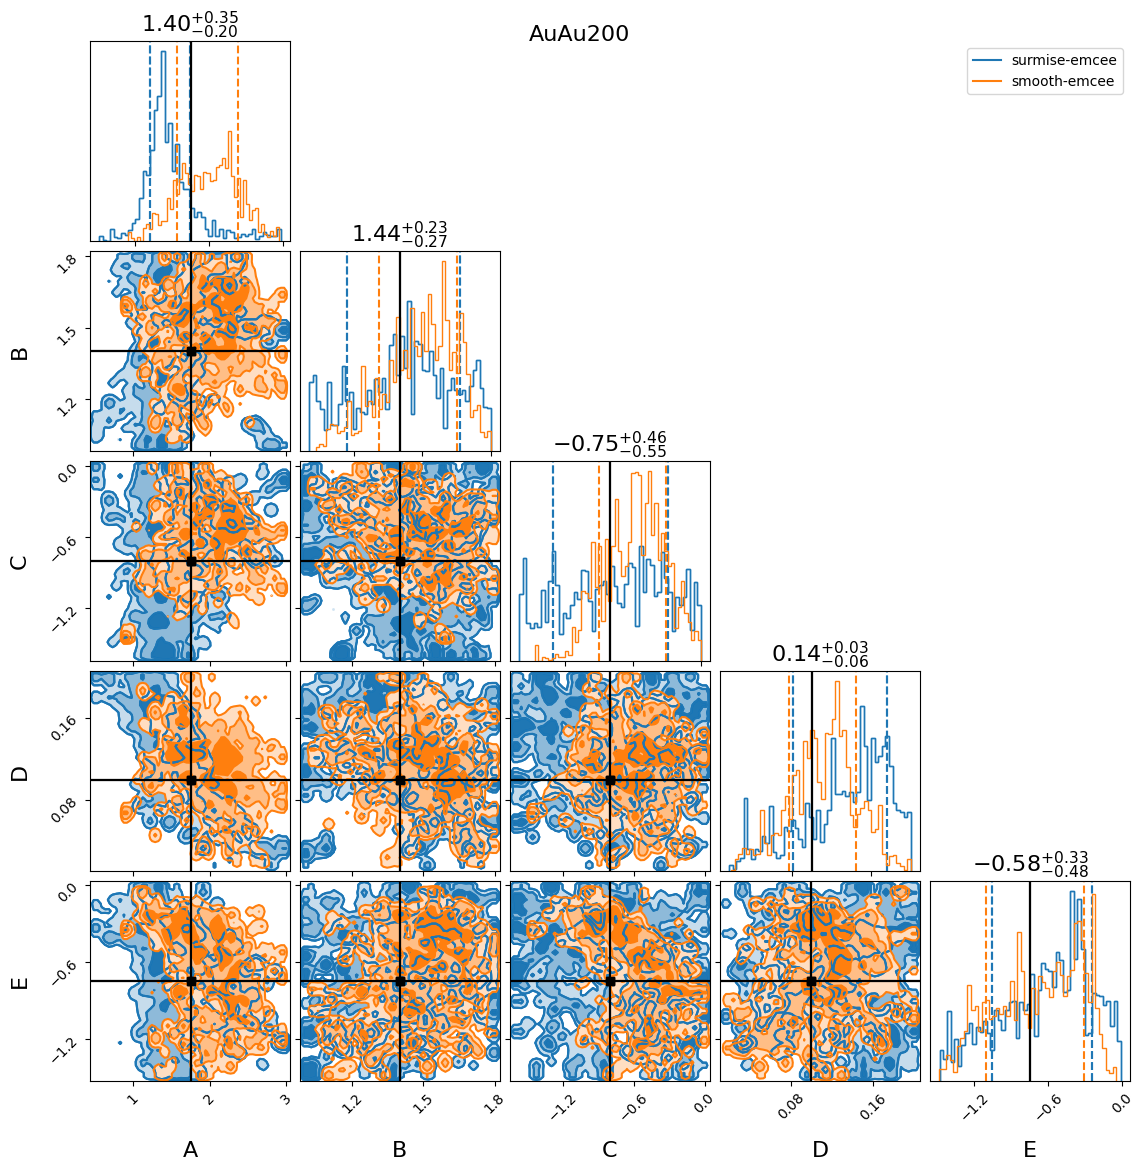

14:21 bilby INFO    : Running for label 'emcee', output will be saved to 'surmise/PbPb2760_results'
14:21 bilby INFO    : Analysis priors:
14:21 bilby INFO    : A=Uniform(minimum=0.5, maximum=3.0, name=None, latex_label=None, unit=None, boundary=None)
14:21 bilby INFO    : B=Uniform(minimum=1.0, maximum=1.8, name=None, latex_label=None, unit=None, boundary=None)
14:21 bilby INFO    : C=Uniform(minimum=-1.6, maximum=0.0, name=None, latex_label=None, unit=None, boundary=None)
14:21 bilby INFO    : D=Uniform(minimum=0.0, maximum=0.2, name=None, latex_label=None, unit=None, boundary=None)
14:21 bilby INFO    : E=Uniform(minimum=-1.5, maximum=0.0, name=None, latex_label=None, unit=None, boundary=None)
14:21 bilby INFO    : Analysis likelihood class: <class '__main__.GaussianLikelihood'>
14:21 bilby INFO    : Analysis likelihood noise evidence: nan
14:21 bilby INFO    : Single likelihood evaluation took nan s
14:21 bilby WARNING : Supplied argument 'verbose' not an argument of 'Emcee', remov

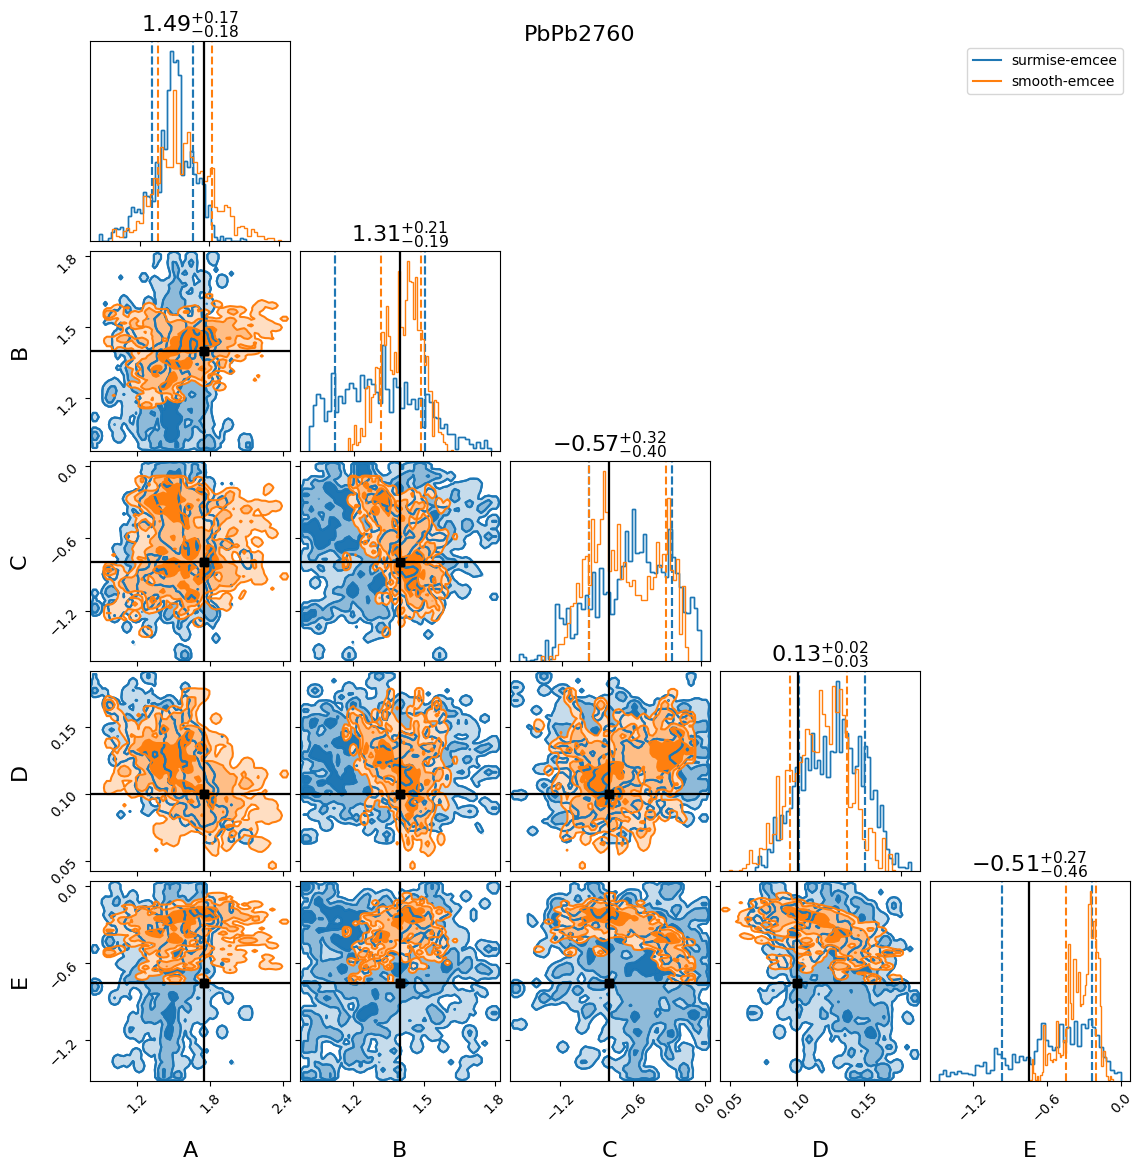

14:22 bilby INFO    : Running for label 'emcee', output will be saved to 'surmise/PbPb5020_results'
14:22 bilby INFO    : Analysis priors:
14:22 bilby INFO    : A=Uniform(minimum=0.5, maximum=3.0, name=None, latex_label=None, unit=None, boundary=None)
14:22 bilby INFO    : B=Uniform(minimum=1.0, maximum=1.8, name=None, latex_label=None, unit=None, boundary=None)
14:22 bilby INFO    : C=Uniform(minimum=-1.6, maximum=0.0, name=None, latex_label=None, unit=None, boundary=None)
14:22 bilby INFO    : D=Uniform(minimum=0.0, maximum=0.2, name=None, latex_label=None, unit=None, boundary=None)
14:22 bilby INFO    : E=Uniform(minimum=-1.5, maximum=0.0, name=None, latex_label=None, unit=None, boundary=None)
14:22 bilby INFO    : Analysis likelihood class: <class '__main__.GaussianLikelihood'>
14:22 bilby INFO    : Analysis likelihood noise evidence: nan
14:22 bilby INFO    : Single likelihood evaluation took nan s
14:22 bilby WARNING : Supplied argument 'verbose' not an argument of 'Emcee', remov

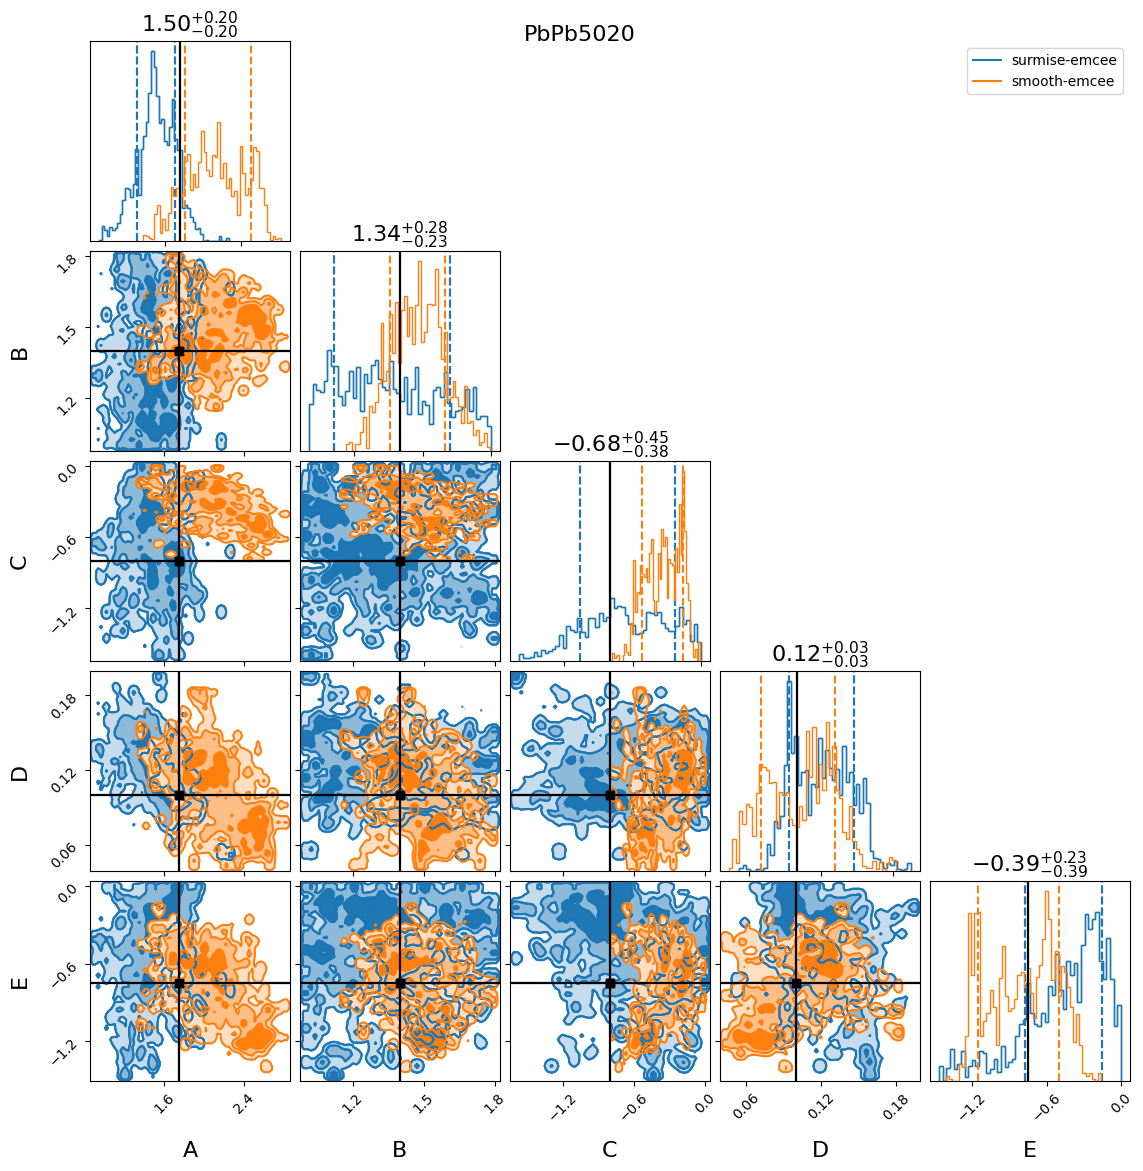

In [10]:
nwalkers = 50
results = dict()
samplers = dict(
    #bilby_mcmc=dict(nsamples=10, L1steps=20, ntemps=10, printdt=10,),
    #dynesty=dict(npoints=50, sample="acceptance-walk", naccept=20),
    #pymultinest=dict(nlive=50),
    #nestle=dict(nlive=500),
    emcee=dict(nwalkers=nwalkers, iterations= Samples, nburn=0.5*Samples),
    #ptemcee=dict(ntemps=10, nwalkers=20, nsamples=10),
)

surmise_result = {}
smooth_result = {}
Sur_samples = {}
Smooth_samples = {}

truths = {
    'A': param_['A'],
    'B': param_['B'],
    'C': param_['C'],
    'D': param_['D'],
    'E': param_['E']
}

for system in ['AuAu200', 'PbPb2760', 'PbPb5020']:
        emulator = Emulators[system]
        outdir=f"surmise/{system}_results"
        label=f"{system}"
        cent_val = 0.05 
        bilby.core.utils.random.seed(seed)
        likelihood = GaussianLikelihood(pT[system].reshape(-1,1), RAA[system], total_high[system], emulator, label, em_type='surmise')
        pos0 = None if not pos else sur_pos[system]

        for sampler in samplers:
            surmise_result[system] = bilby.core.sampler.run_sampler(
                likelihood=likelihood,
                priors=priors,
                sampler=sampler,
                outdir=outdir,
                label=sampler,
                pos0=pos0,
                resume=True,
                clean=False,
                verbose=True,
                **samplers[sampler]
            )
            results['surmise_'+ sampler] = surmise_result[system]

        pos0 = None if not pos else smooth_pos[system]
        
        path = f"{work_path}/smooth_emulators/{system}/"
        os.chdir(path)
        import emulator_smooth
        emulator = emulator_smooth.emulator_smooth()
        os.chdir(work_path)
        
        outdir=f"smooth_emulators/{system}_results"
        likelihood = GaussianLikelihood(
            pT[system], 
            RAA[system], 
            total_high[system], 
            emulator,
            label,
            em_type='smooth'
        )


        for sampler in samplers:
            smooth_result[system] = bilby.core.sampler.run_sampler(
                likelihood=likelihood,
                priors=priors,
                sampler=sampler,
                outdir=outdir,
                label=sampler,
                pos0=pos0,
                resume=True,
                clean=False,
                verbose=True,
                **samplers[sampler]
            )
            results['smooth_' + sampler] = smooth_result[system]
            
            if sampler == 'emcee':
                Sur_samples[system] = surmise_result[system].samples
                Smooth_samples[system] = smooth_result[system].samples
                sur_pos[system]=Sur_samples[system][-nwalkers:]
                smooth_pos[system]=Smooth_samples[system][-nwalkers:]
                if system == 'AuAu200':
                    with open('pos0.txt', 'w') as f:
                        f.write(f"sur_pos_{system}\n")
                        np.savetxt(f, sur_pos[system], delimiter=',')
        
                        f.write(f"smooth_pos_{system}\n")
                        np.savetxt(f, smooth_pos[system], delimiter=',')
                else:
                    with open('pos0.txt', 'a') as f:
                        f.write(f"sur_pos_{system}\n")
                        np.savetxt(f, sur_pos[system], delimiter=',')

                        f.write(f"smooth_pos_{system}\n")
                        np.savetxt(f, smooth_pos[system], delimiter=',')
        
        # Make a corner plots.
        fig = bilby.core.result.plot_multiple(
            list(results.values()), labels=list(results.keys()), truth=truths, truth_color='black', save=True, outdir=f'{system}.png'
        )
        plt.suptitle(system, fontsize=16)
        plt.show()
        plt.close(fig)

## Trace Plots

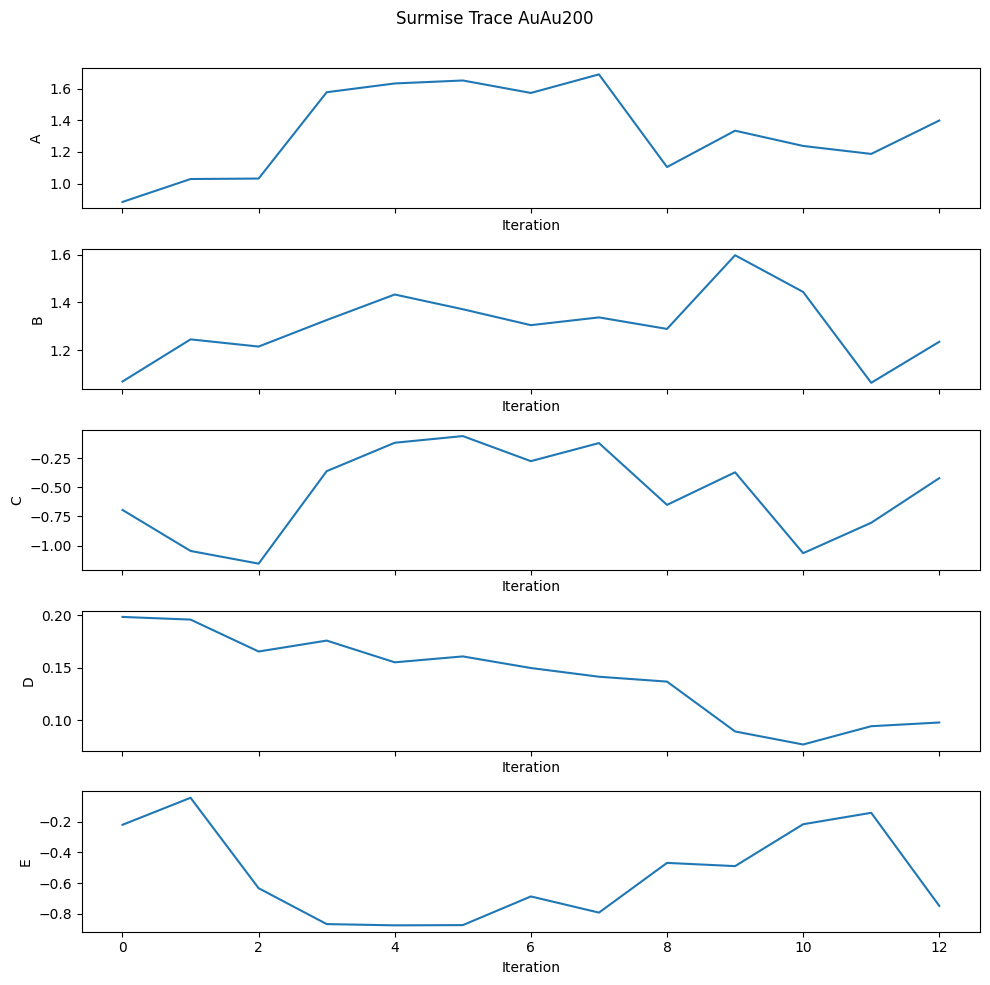

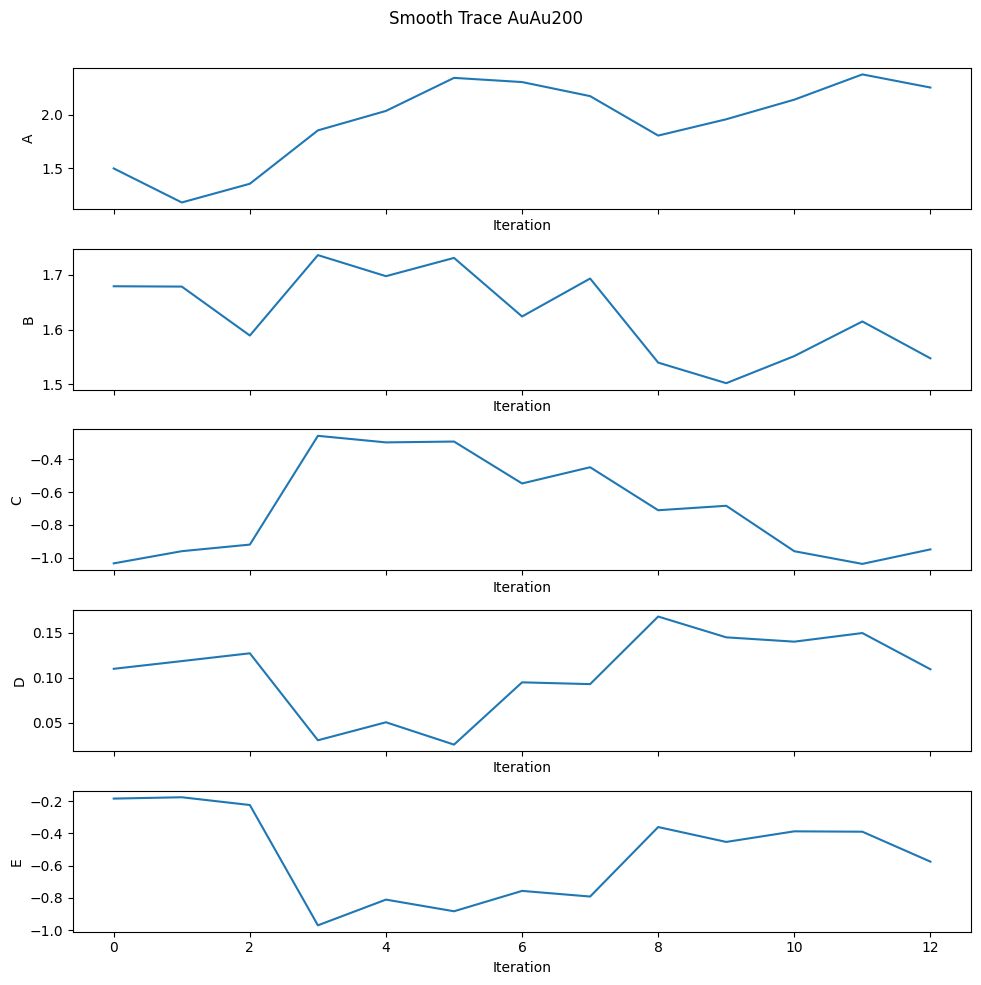

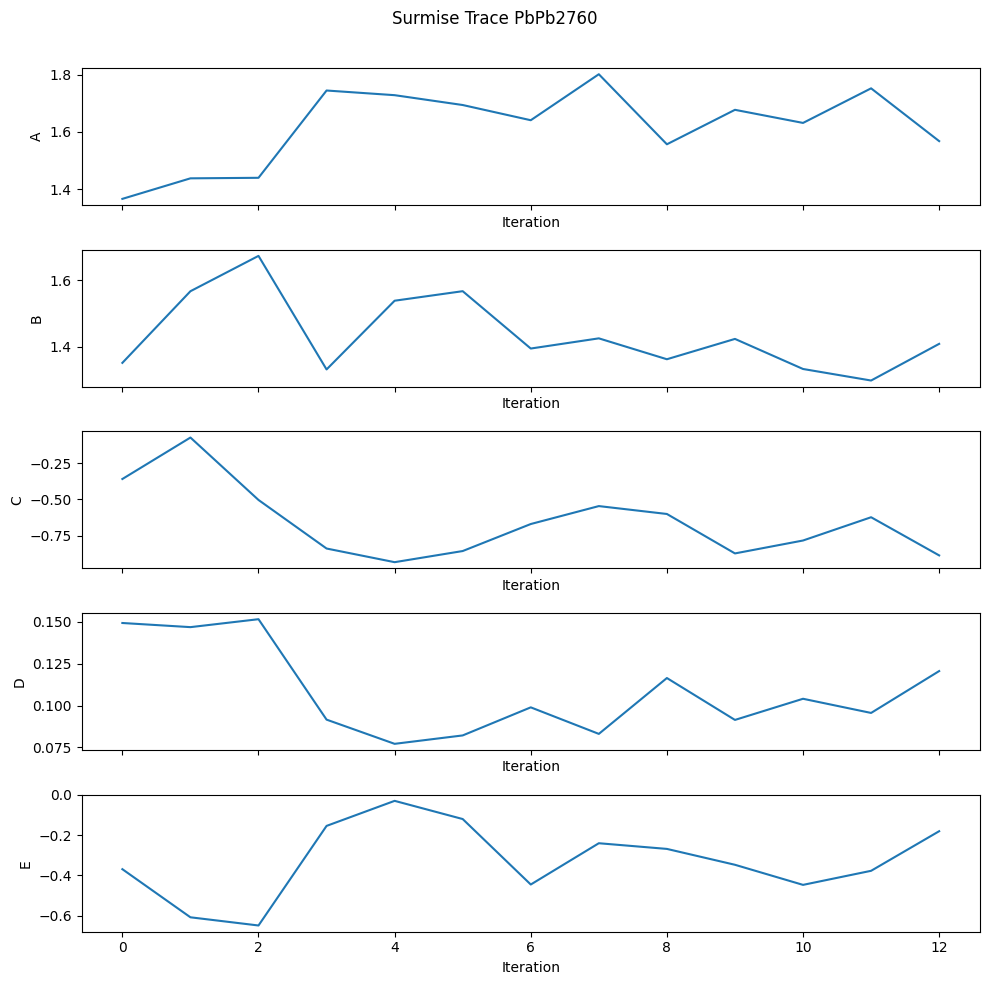

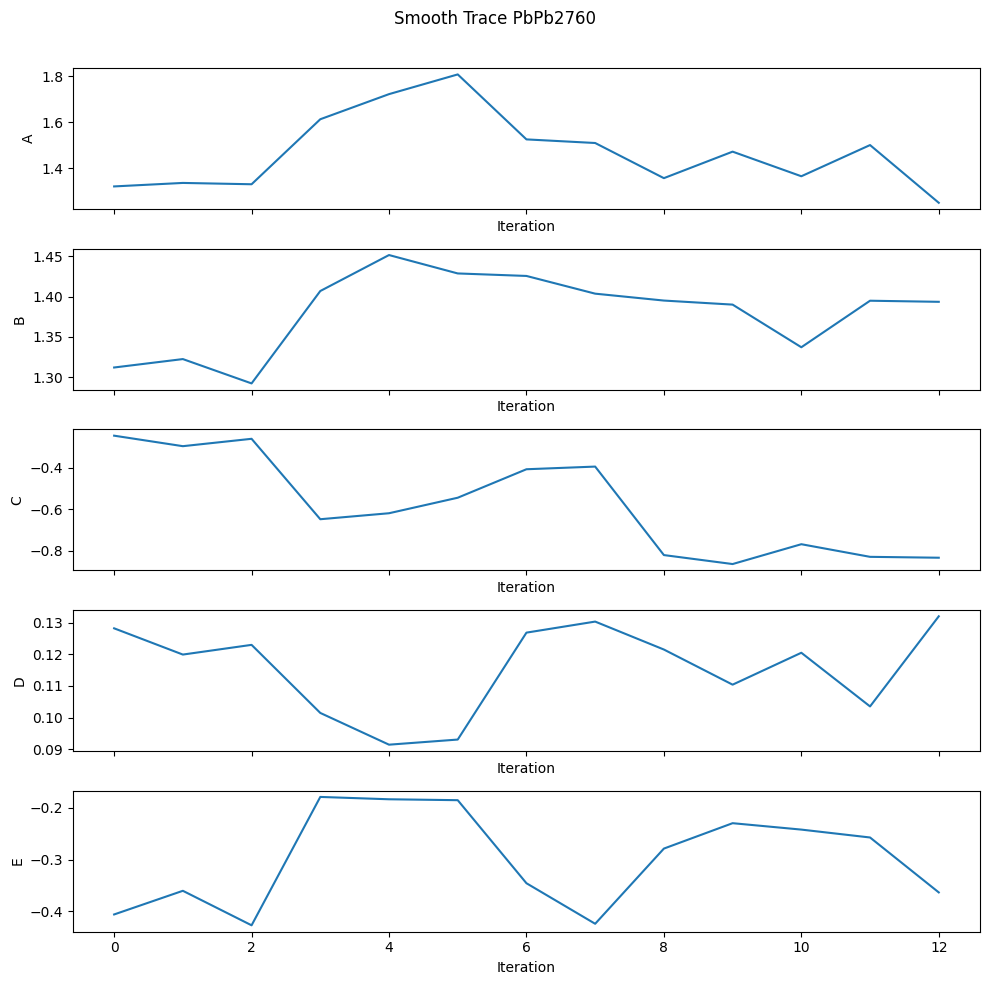

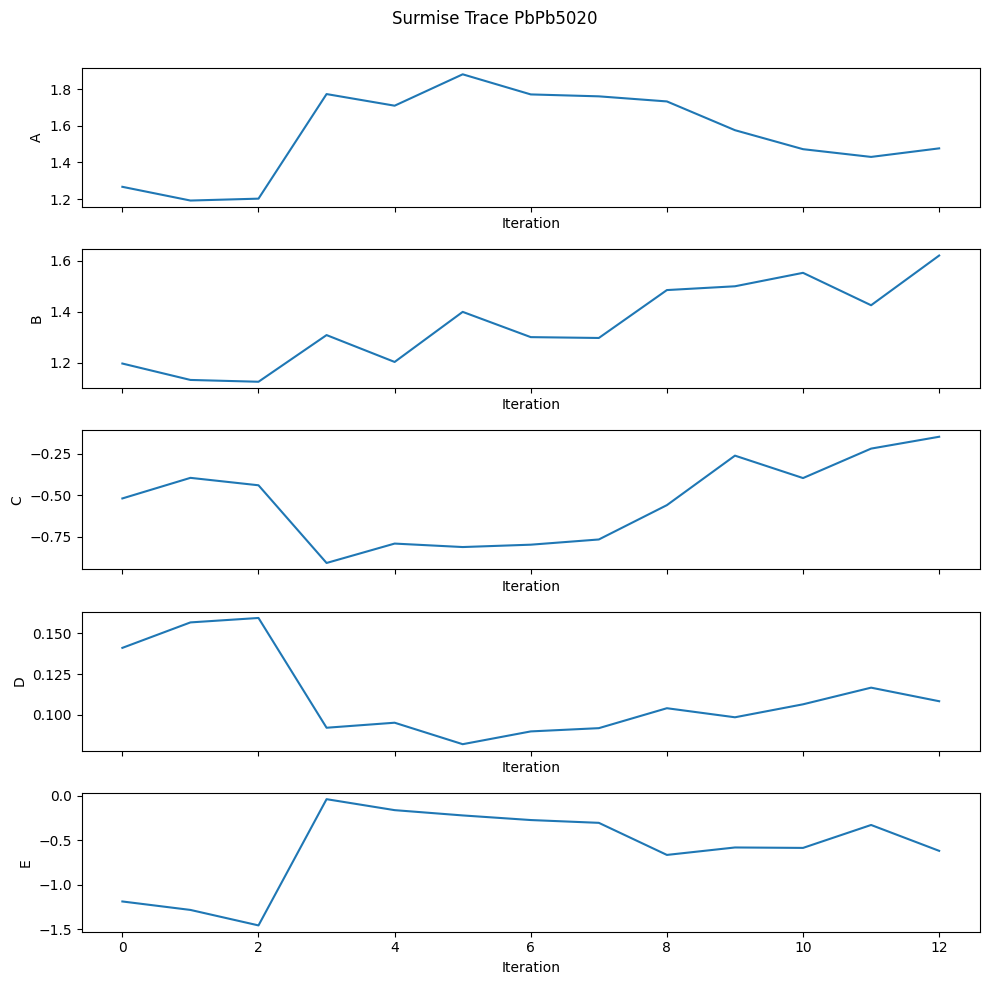

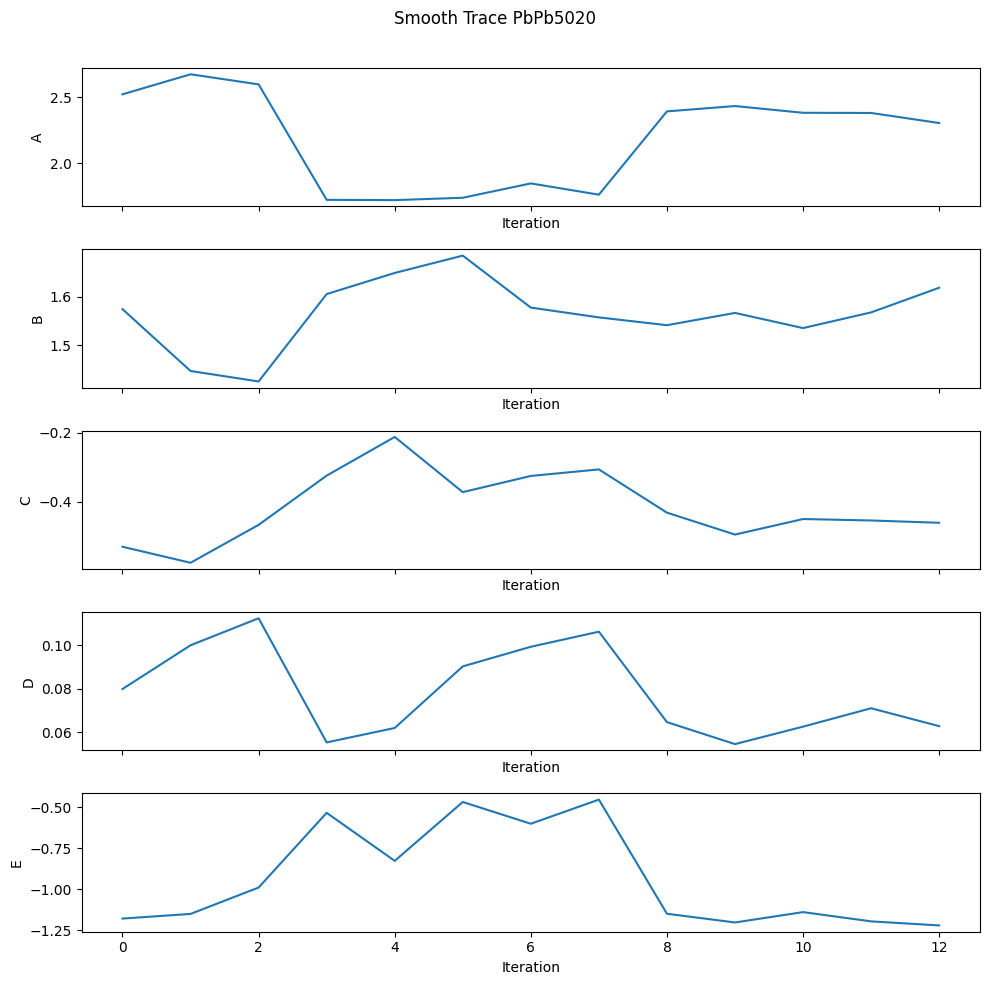

In [11]:
last_15_smooth = {}
last_15_surmise = {}

for system in ['AuAu200', 'PbPb2760', 'PbPb5020']:
    last_15_surmise[system] = Sur_samples[system][int(0.95 * len(Sur_samples[system])):]
    last_15_smooth[system] = Smooth_samples[system][int(0.95 * len(Smooth_samples[system])):]
    # Apply thinning: select every 10th sample
    thin_surmise = last_15_surmise[system][::10]
    thin_smooth = last_15_smooth[system][::10]
    # Plot the thinned samples
    plots.plot_trace(thin_surmise, parameter_names, 'Surmise Trace '+ system)
    plots.plot_trace(thin_smooth, parameter_names, 'Smooth Trace '+ system)

## Result Plots

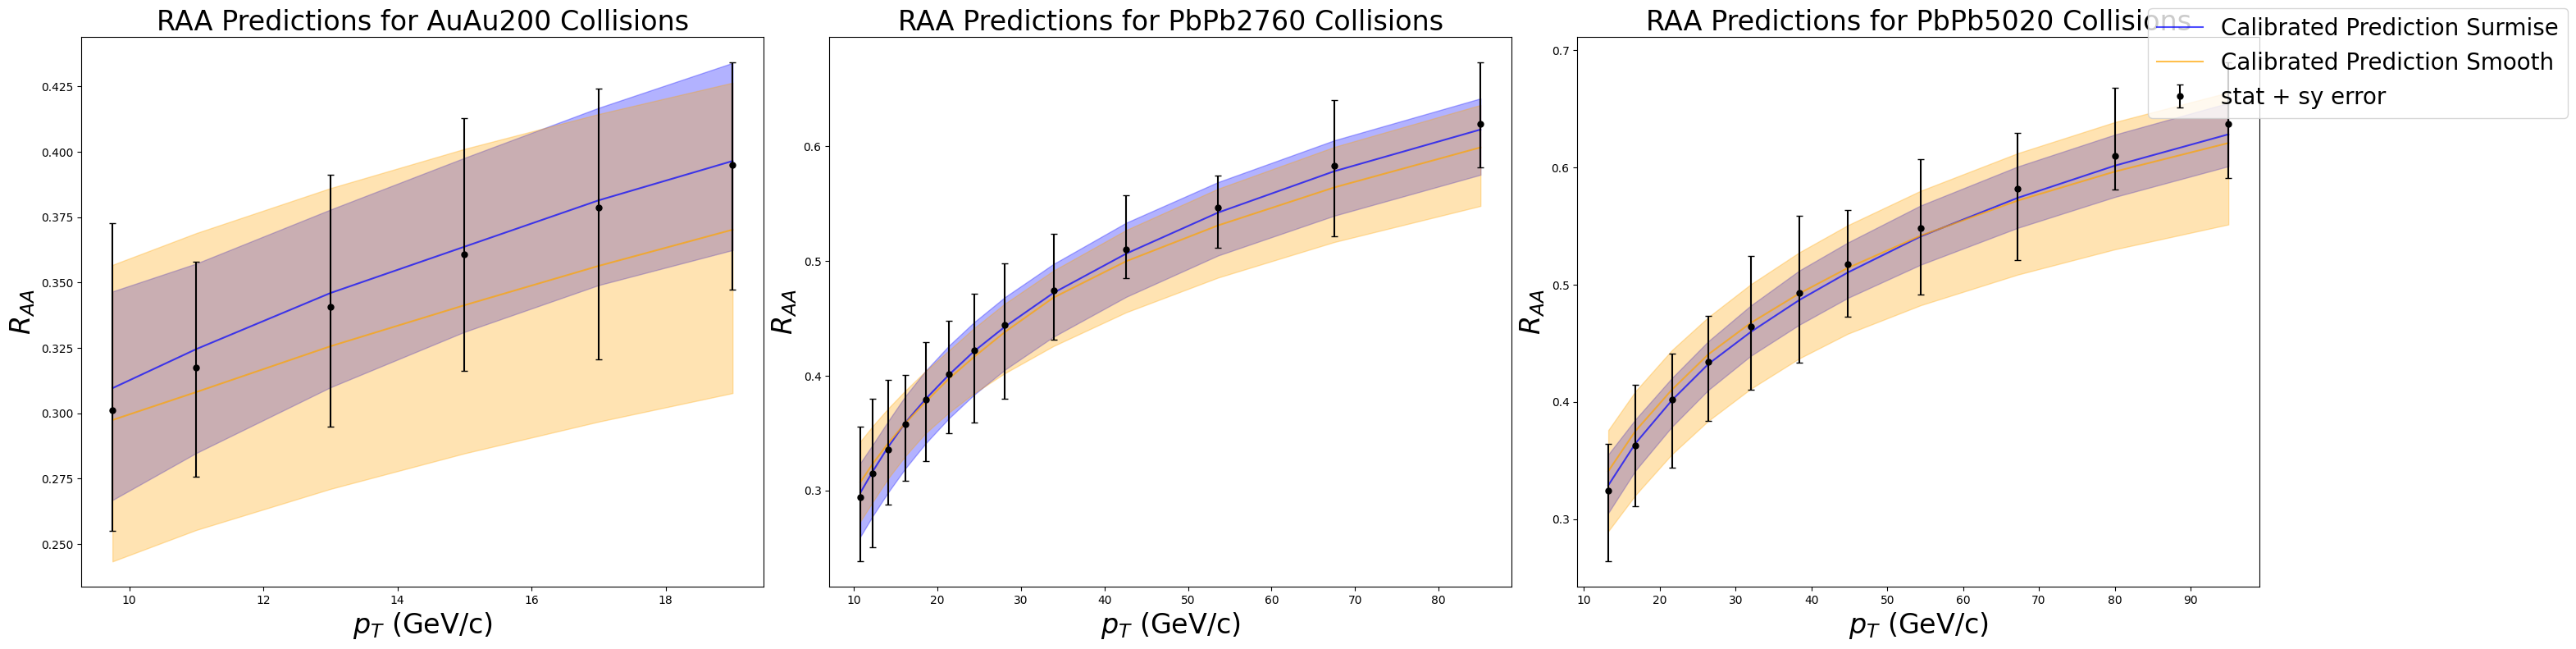

In [12]:
size = 50

# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(30, 8))

handles, labels = [], []
legend_added = False  

for i, system in enumerate(['AuAu200', 'PbPb2760', 'PbPb5020']):
    ax = axes[i]  

    # Surmise model predictions
    sur_rows = np.random.choice(Sur_samples[system].shape[0], size=size, replace=False)
    samples = Sur_samples[system][sur_rows]
    sur_post = Emulators[system].predict(pT[system].reshape(-1, 1), samples).mean()
    sur_upper = np.percentile(sur_post.T, 97.5, axis=0)
    sur_lower = np.percentile(sur_post.T, 2.5, axis=0)
    sur_median = np.percentile(sur_post.T, 50, axis=0)
    
    # Smooth model predictions
    smooth_rows = np.random.choice(Smooth_samples[system].shape[0], size=size, replace=False)
    params = Smooth_samples[system][smooth_rows]
    model, _ = Smooth.predict(params, system)
    smooth_post = np.array(model)
    smooth_upper = np.percentile(smooth_post, 97.5, axis=0)
    smooth_lower = np.percentile(smooth_post, 2.5, axis=0)
    smooth_median = np.percentile(smooth_post, 50, axis=0)

    # Plot Surmise model
    line1 = ax.plot(pT[system], sur_median, label=f'Surmise', color='blue', alpha=0.7)
    ax.fill_between(pT[system], sur_lower, sur_upper, color='blue', alpha=0.3)

    # Plot Smooth model
    line2 = ax.plot(pT[system], smooth_median, label=f'Smooth', color='orange', alpha=0.7)
    ax.fill_between(pT[system], smooth_lower, smooth_upper, color='orange', alpha=0.3)

    # Plot error bars
    line3 = ax.errorbar(pT[system], RAA[system], yerr=[total_low[system], total_high[system]], 
                        color='black', fmt='o', markersize=5, capsize=3, label=f'stat + sys error')
    
    ax.set_xlabel('$p_T$ (GeV/c)', fontsize=24)
    ax.set_ylabel('$R_{AA}$', fontsize=24)
    ax.set_title(f'RAA Predictions for {system} Collisions', fontsize=24)

    if not legend_added:
        handles.extend([line1[0], line2[0], line3])
        labels.extend([f'Calibrated Prediction Surmise', f'Calibrated Prediction Smooth', f'stat + sy error'])
        legend_added = True 


fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1), fontsize=20)


plt.tight_layout()
plt.subplots_adjust(right=0.92)